In [12]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler                
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
input=1000

# create class
class LogisticRegression(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(LogisticRegression,self).__init__()
        # Linear function.
        self.linear = nn.Linear(input_dim,output_dim)

    def forward(self,x):
        return nn.functional.sigmoid(self.linear(x))

In [13]:
columns_names=['user_id','item_id','rating','timestamp']
df=pd.read_csv("D:/viva/Intern/Movielens/archive/ml-100k/u1.base", sep="\t",names=columns_names, encoding="latin-1").head(input)

# print(df.head().dtypes)

In [14]:
columns_names_movies=['item_id','title','date', "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16", "A17", "A18", "A19", "A20", "A21"]
movies = pd.read_csv("D:/viva/Intern/Movielens/archive/ml-100k/u.item", sep="|", names=columns_names_movies, encoding="latin-1").head(input)

# print(movies.head())

In [15]:
X_data=pd.merge(df, movies, on="item_id")
X_data=X_data.drop(columns=["title","date", "A1", "rating","A2"])
y_data=df.drop(columns=["user_id", "item_id", "timestamp"])

# print(X_data.dtypes)
# print(X_data.head())
# print(y_data.head())

In [16]:
data=pd.read_csv("D:/viva/Intern/Movielens/archive/ml-100k/u1.test", sep="\t",names=['user_id','item_id',"rating",'timestamp'], encoding="latin-1").head(input)
data_test=pd.merge(pd.read_csv("D:/viva/Intern/Movielens/archive/ml-100k/u.item", sep="|", names=columns_names_movies, encoding="latin-1").head(input),data,on="item_id")
X_data_test=data_test.drop(columns=["rating", "title", "date","A1","A2"])
y_data_test=data_test.drop(columns=['user_id','item_id','timestamp','title','date', "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16", "A17", "A18", "A19", "A20", "A21"])

# print(y_data_test)

In [17]:
def IQR(df, columns):
    cleaned_df = df.copy()
    for column in columns:
        # IQR
        q75, q25 = np.percentile(cleaned_df[column], [75, 25])
        iqr = q75 - q25
        lower_bound = q25 - 1.5 * iqr
        upper_bound = q75 + 1.5 * iqr
        # remove outliers
        cleaned_df = cleaned_df[(cleaned_df[column] >= lower_bound) & (cleaned_df[column] <= upper_bound)]

    return cleaned_df

X_data_scaled = pd.DataFrame(MinMaxScaler(feature_range=(1, 5)).fit_transform(X_data), columns=X_data.columns)
X_data_test_scaled = pd.DataFrame(MinMaxScaler(feature_range=(1, 5)).fit_transform(X_data_test), columns=X_data_test.columns)
input_size = Variable(torch.Tensor(IQR(X_data_scaled,['user_id','item_id','timestamp']).values), requires_grad=True)
input_size_test = Variable(torch.Tensor(IQR(X_data_test_scaled,['user_id','item_id','timestamp']).values), requires_grad=True)
# input_size_reshape=input_size.reshape() "Khi nào cần thì xài"
convert_prob=nn.Sigmoid()
output_size=convert_prob(Variable(torch.Tensor(IQR(y_data,["rating"]).values[:len(input_size)]), requires_grad=True))
output_size_test=convert_prob(Variable(torch.Tensor(IQR(y_data_test,["rating"]).values[:len(input_size_test)]), requires_grad=True))
output_size_reshape=output_size.reshape(1,-1)
output_size_test_reshape=output_size_test.reshape(1,-1)

# print(input_size, input_size_test)
print(input_size.shape, input_size_test.shape)
# print(output_size_reshape, output_size_test_reshape)
print(output_size_reshape.shape, output_size_test_reshape.shape)

torch.Size([1000, 22]) torch.Size([1000, 22])
torch.Size([1, 1000]) torch.Size([1, 1000])


In [20]:

# define model
model = LogisticRegression(22, 1) 

# BCE
bce = nn.BCELoss(size_average=True)

# Optimization (find parameters that minimize error)
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001)

# train model
loss_list = []
for iteration in range(101):

    # optimization
    optimizer.zero_grad() 
    
    # Forward to get output
    results = model(input_size).reshape(1,-1)
    # print(results)
    # print(output_size_reshape)
    # Calculate Loss
    loss = bce(results, output_size_reshape)
    
    # backward propagation
    loss.backward(retain_graph=True)
    
    # Updating parameters
    optimizer.step()
    
    # store loss
    loss_list.append(loss.data)

# print(loss_list)


Binary Cross Entropy is 0.28


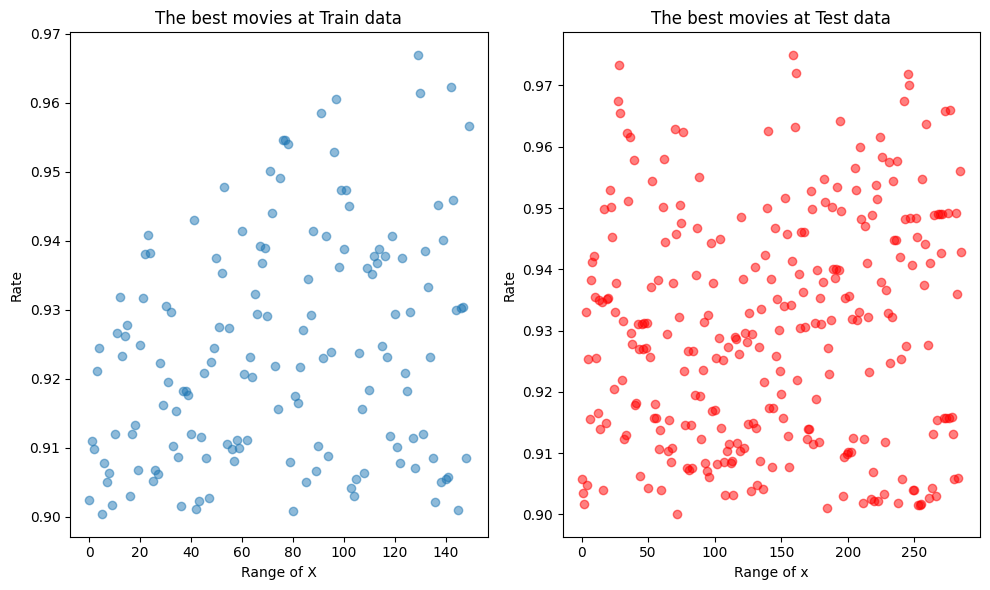

In [21]:
predicted_train = model(input_size).reshape(1,-1)
predicted_test = model(input_size_test).reshape(1,-1)
y_predicted_train=predicted_train.data.detach().numpy()[predicted_train.data.detach().numpy()>=0.9]
y_predicted_test=predicted_test.data.detach().numpy()[predicted_test.data.detach().numpy()>=0.9]
BCE= bce(predicted_test, output_size_test_reshape)
print(f"Binary Cross Entropy is {BCE:.2f}")
# print(predicted_train.data.detach().numpy().shape, predicted_test.data.detach().numpy().shape)

# Visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
# x_input_size=np.arange(0, len(input_size),1)
# x_input_size_test=np.arange(0, len(input_size_test),1)
plt.subplot(1,2,1)
axes[0].scatter(np.arange(0,len(y_predicted_train)),y_predicted_train,alpha=0.5)
axes[0].set_title('The best movies at Train data')
axes[0].set_xlabel('Range of X')
axes[0].set_ylabel('Rate')
plt.subplot(1,2,2)
axes[1].scatter(np.arange(0,len(y_predicted_test)), y_predicted_test, color="red",alpha=0.5)
axes[1].set_title('The best movies at Test data')
axes[1].set_xlabel('Range of x')
axes[1].set_ylabel('Rate')
plt.tight_layout()
plt.show()